In [1]:
from IPython.display import display
from IPython.display import Latex
import blosc
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pytz
import pickle
import os
import pandas as pd
from platform import python_version
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tslearn.clustering import TimeSeriesKMeans

if python_version().startswith('3.7'):
    import pickle5 as pickle

FSIZE = "full" #"tiny", "small" or "full"

fdir = os.path.join('pickles', 'temporal_analysis')
os.makedirs(fdir, exist_ok = True)

with open(os.path.join(fdir, f'decomposition-runtime-{FSIZE}-hourly.pc'), 'rb') as f:
    decomp_hourly = pickle.loads(blosc.decompress(f.read()))

with open(os.path.join(fdir, f'decomposition-runtime-{FSIZE}-daily.pc'), 'rb') as f:
    decomp_daily = pickle.loads(blosc.decompress(f.read()))

/home/leonard/.local/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
from notebook_shared import decomposeutils as dcu
from notebook_shared import utils
from notebook_shared import violinplotutil

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

In [3]:
def get_decomposition_data(decomp, col='observed'):
    if col == 'observed':
        series = getattr(decomp['data'], col)['runtime'].rename(col)
    else:
        series = getattr(decomp['data'], col).rename(col)
    return series

In [4]:
def convert_decomp_series_to_df(series, timezone = None, strftime = None):
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        if (timezone is not None):
            df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime(strftime)
        else:
            df['hist'] = df.index.tz_localize('UTC').strftime(strftime)
        return df

In [5]:
def boxplot_hourly(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['parameters']['timezone']
        region = decomp['parameters']['region']
        series = get_decomposition_data(decomp['decomposition'], col)
        df = convert_decomp_series_to_df(series, timezone, '%H')
        
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    
    bxp = fdf[[col, 'hist']]
    utils.boxplot(ax, bxp, "", lambda x: x, with_mean=True, by='hist')
    
    ax.set_title(title)
    ax.set_xlabel('')
    
    data = fdf[["hist", col]].groupby(by='hist')[col].describe()
    return data

In [6]:
def boxplot_daily(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['parameters']['timezone']
        region = decomp['parameters']['region']
        
        if col == 'observed':
            series = getattr(decomp['decomposition']['data'], col)['runtime'].rename(col)
        else:
            series = getattr(decomp['decomposition']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%w")
    
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    fdf['hist'] = fdf['hist'].replace('0', '7')
    fdf = fdf.sort_values(by=['hist', col])
    
    #bxp = fdf.boxplot(col, by='hist', showfliers=False, ax=ax)
    bxp = fdf[[col, 'hist']]
    utils.boxplot(ax, bxp, "", lambda x: x, with_mean=True, by='hist')
    
    
    ax.set_title(title)
    ax.set_xlabel('')
    
    data = fdf[["hist", col]].groupby(by='hist')[col].describe()
    return data

In [7]:
def violinplot_hourly(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['parameters']['timezone']
        region = decomp['parameters']['region']
        
        if col == 'observed':
            series = getattr(decomp['decomposition']['data'], col)['runtime'].rename(col)
            series = series.astype(np.float64) #TODO: check if fix neccesary for vio (box not)
        else:
            series = getattr(decomp['decomposition']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%H")

        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)  
    
    fdf = fdf.sort_values(by=['hist', col])
    ax = violinplotutil.violinplot(x="hist", y=col, cut=0, data=fdf, ax=ax, inner='box', rot=45, linewidth=0.1, customlineswidth=1.5)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
    # Set better default lims:
    data = fdf[["hist", col]].groupby(by='hist')[col].describe()
    i25 = data['25%'].min()
    i75 = data['75%'].max()
    
    iqr = (i75 - i25)
    whisker_lim = 1.5 * iqr
    ax.set_ylim(i25 - whisker_lim , i75 + whisker_lim)
    return data

In [8]:
def violinplot_daily(data, ax, title, col='seasonal'):
    fdf = None
    for decomp in data:
        timezone = decomp['parameters']['timezone']
        region = decomp['parameters']['region']
        
        if col == 'observed':
            series = getattr(decomp['decomposition']['data'], col)['runtime'].rename(col)
            series = series.astype(np.float64) #TODO: check if fix neccesary for vio (box not)
        else:
            series = getattr(decomp['decomposition']['data'], col).rename(col)
        
        df = pd.DataFrame(series)
        df.set_index(pd.DatetimeIndex(df.index), drop=False, inplace=False)
        df['hist'] = df.index.tz_localize('UTC').tz_convert(timezone).strftime("%w")
    
        if fdf is None:
            fdf = df
        else:
            fdf = fdf.append(df)
    
    fdf['hist'] = fdf['hist'].replace('0', '7')
    
    fdf = fdf.sort_values(by=['hist', col])
    ax = violinplotutil.violinplot(x="hist", y=col, cut=0, data=fdf, ax=ax, inner='box', rot=45, linewidth=0.1, customlineswidth=1.5)
    
    ax.set_title(title)
    ax.set_xlabel('')
    
    # Set better default lims:
    data = fdf[["hist", col]].groupby(by='hist')[col].describe()
    i25 = data['25%'].min()
    i75 = data['75%'].max()
    
    iqr = (i75 - i25)
    whisker_lim = 1.5 * iqr
    ax.set_ylim(i25 - whisker_lim , i75 + whisker_lim)
    return data

In [9]:
def get_normalized_series(series, new_name):
    series = series.rename(new_name)
    # Normalize Series
    normalized_series = (series-series.min()) / (series.max() - series.min())
    return normalized_series

In [10]:
def join_decompositions(decompositions, with_tz = True, strftime='%H', col='observed'):
    
    full_dataset = None
    
    for decomp in decompositions:
        timezone = None
        if with_tz:
            timezone = decomp['parameters']['timezone']
        
        region = decomp['parameters']['region']
        provider = decomp['parameters']['provider']
        
        series = get_decomposition_data(decomp['decomposition'], col)
        
        df = convert_decomp_series_to_df(series, timezone, strftime) 
        df['region'] = region
        df['timezone'] = timezone
        df['provider'] = provider
        
        if full_dataset is None:
            full_dataset = df
        else:
            full_dataset = full_dataset.append(df)
    
    return full_dataset

In [11]:
def get_heatmap_dataset(provider, with_tz, col, decomp, strftime, with_regions=True, data_col='50%'):
    
    decomp = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp))
    
    df = join_decompositions(decomp, with_tz=with_tz, strftime=strftime, col=col)
    
    normalized_series = []
    data_series = []
    normalized_series.append(get_normalized_series(df.groupby(['hist'])[col].describe()[data_col], f'{provider}'))
    data_series.append(df.groupby(['hist'])[col].describe()[data_col].rename(f'{provider}'))
    
    if with_regions:
        for region in list(df['region'].unique()):
                region_df = df[df['region'] == region]
                normalized_series.append(get_normalized_series(region_df.groupby(['hist'])[col].describe()[data_col], f'{region}'))
                data_series.append(region_df.groupby(['hist'])[col].describe()[data_col].rename(f'{region}'))
        
    ndf = pd.concat(normalized_series, axis=1)
    ddf = pd.concat(data_series, axis=1)
    
    # Change DOW in 'Mon -> Sun'
    if (strftime == "%w"):
        ndf = ndf.reset_index()
        ndf['hist'] = ndf['hist'].replace('0', '7')
        ndf = ndf.sort_values(by=['hist'])
        ndf = ndf.set_index('hist')
        
        ddf = ddf.reset_index()
        ddf['hist'] = ddf['hist'].replace('0', '7')
        ddf = ddf.sort_values(by=['hist'])
        ddf = ddf.set_index('hist')
        
    return {'normalized_df': ndf.transpose(), 'data_df': ddf.transpose() }

In [12]:
def plot_heatmap(dataset, ax, with_normalized_value=False, cbar=False):
    
    label_df = dataset['data_df'].round(1)
    if with_normalized_value:
        label_df = dataset['normalized_df'].combine(
            dataset['data_df'],
            lambda x,y: x.round(1).astype('string') + '\n (' + y.round(1).astype(str) + ')'
        )

    ax = sns.heatmap(tdf['normalized_df'], annot=label_df, fmt="", linewidths=.5, ax=ax, cbar=cbar, cmap="Reds", center=0.5)
    return ax

In [13]:
#inspired by https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    for i in range(data.shape[0]):
        shift_i = 0
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            # full_tdfd
            if (shift_i % 2 == 1):
                text = im.axes.text(j, i, round(full_tdfd.iloc[i,j],1), **kw)
            else:
                text = im.axes.text(j, i, round(full_tdfd.iloc[i,j],1), **kw)
            # shift_i += 1
            #text = im.axes.text(j, i, round(data[i, j],2), **kw)
    
def heatmap_improved(ax, full_tdfn, full_tdfd, title, x_label, rot=90, with_cbar=True, cbarstrink=1, label_coords=None):

    normdata = np.linspace(0, 1, 6)
    norm = matplotlib.colors.BoundaryNorm(normdata, 5)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: normdata[x])
    cmap = plt.get_cmap('Reds', lut=5)
    im = ax.imshow(full_tdfn, cmap=cmap, aspect='auto')

    ax.set_yticks(range(0, len(full_tdfn.index)))
    yticks = list(full_tdfn.index)
    ax.set_yticklabels(yticks, rotation=rot, va="center")
    ax.grid(False)
    ax.set_xticks(range(0,len(full_tdfn.columns)))
    cbar_kw=dict(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    
    if with_cbar:
        if cbarstrink != 1:
            axins = inset_axes(ax,
                        width="2%",  
                        height="50%",
                        loc='center right',
                        borderpad=-2
                       )

            cbar = ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=cbarstrink, cax=axins, **cbar_kw)
            cbar.set_ticklabels(['0\n(Low)', '0.2', '0.4', '0.6', '0.8', '1\n(High)'])
            cbar.ax.set_ylabel('Level', rotation=-90, va="bottom")
            if label_coords is not None:
                cbar.ax.yaxis.set_label_coords(*label_coords)
        else:
            cbar = ax.figure.colorbar(im, ax=ax, pad=0.01, **cbar_kw)
            cbar.set_ticklabels(['0\n(Low)', '0.2', '0.4', '0.6', '0.8', '1\n(High)'])
            cbar.ax.set_ylabel('Level', rotation=-90, va="bottom")
            if label_coords is not None:
                cbar.ax.yaxis.set_label_coords(*label_coords)
            ax.set_ylabel(title)
    ax.set_xlabel(x_label)
    ax.tick_params(axis='y', which='major', pad=-5)
    annotate_heatmap(im, data=full_tdfn, valfmt=fmt, threshold=0.70, textcolors=("black", "white"))

In [14]:
aws_hourly_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "AWS", decomp_hourly))
azure_hourly_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "AZURE", decomp_hourly))
gcp_hourly_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "GCP", decomp_hourly))

aws_daily_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "AWS", decomp_daily))
azure_daily_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "AZURE", decomp_daily))
gcp_daily_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == "GCP", decomp_daily))

In [15]:
# Find Optimal Number Of Clusters For Timerseries:
def elbow_plots(decomposes, title, ax, max_k=15):
    cluster_data = {}
    for decomp in decomposes:
        region = decomp['parameters']['region']
        cluster_data[region] = decomp['decomposition']['data'].trend.values
        x = decomp['decomposition']['data'].trend

    X = pd.DataFrame.from_dict(cluster_data).transpose()

    dist = []
    K = range(1, max_k)
    for k in K:
        model = TimeSeriesKMeans(n_clusters=k, max_iter=10, random_state=0)
        Y = model.fit(X)
        dist.append(model.inertia_)
    
    ax.plot(K, dist, 'bx-')
    ax.set_xlabel = 'Parameter K for KMeans'
    ax.set_ylabel(f'Sum of squard distance\n{title}')
    return dist

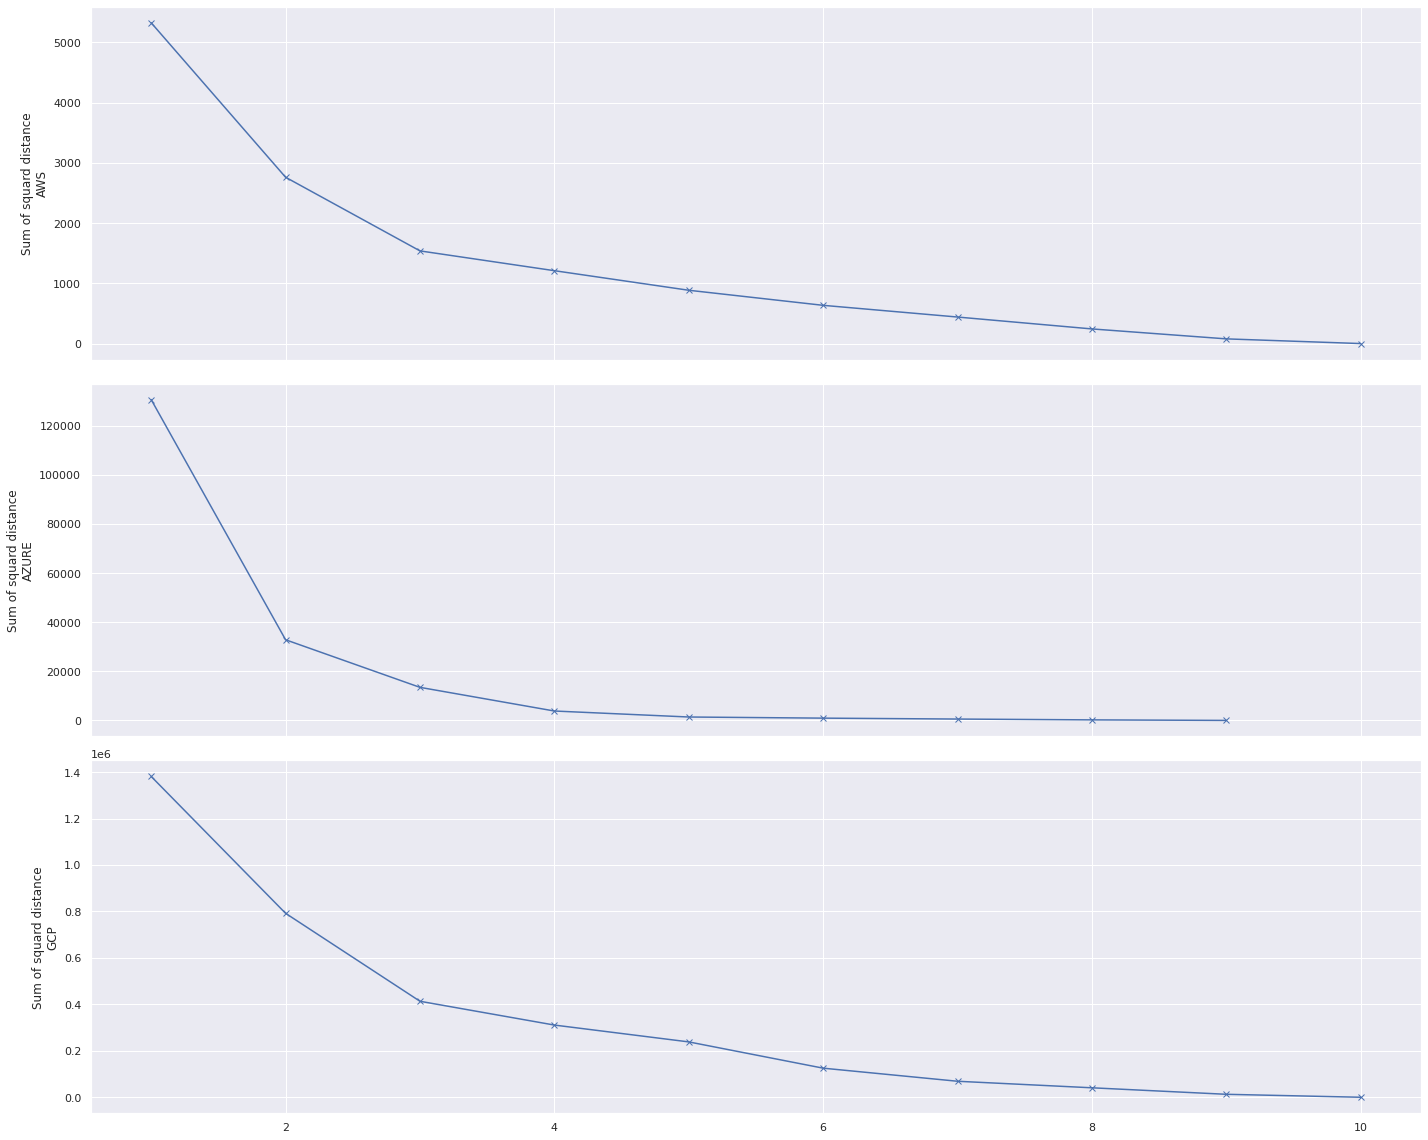

In [16]:
fig, axis = plt.subplots(figsize=(20,16), nrows=3, sharex=True)
elbow_plots(aws_hourly_decomposes, 'AWS', axis[0])
elbow_plots(azure_hourly_decomposes, 'AZURE', axis[1])
elbow_plots(gcp_hourly_decomposes, 'GCP', axis[2])
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_trend_overview_elbow'])

In [17]:
def get_new_order(clustering, handels, labels):
    new_handles = []
    new_legend = []

    for key, regions in clustering.items():
        handle_index = labels.index(key)
        new_legend.append(key)
        new_handles.append(handles[handle_index])
        for region in regions:
            handle_index = labels.index(region)
            new_legend.append(region)
            new_handles.append(handles[handle_index])
    
    return new_handles, new_legend

/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator


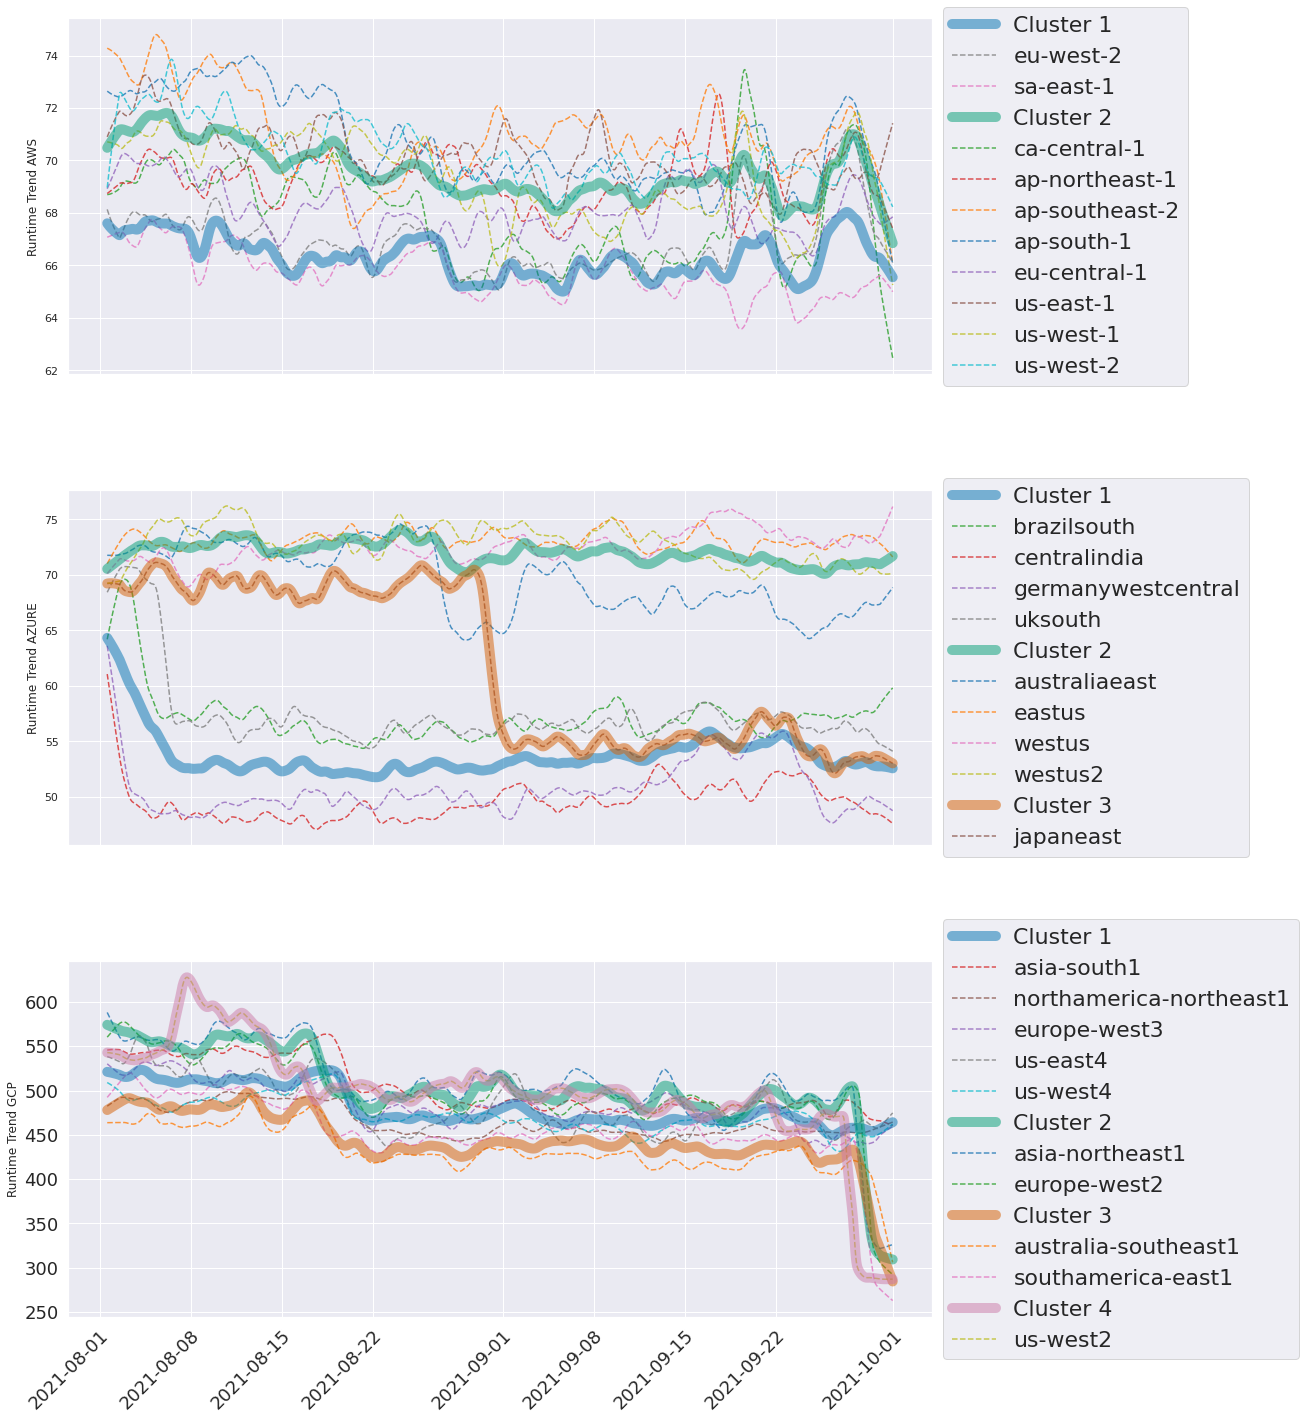

In [18]:
fig, axis = plt.subplots(figsize=(16,20), nrows=3, sharex=True)
sns.set(font_scale=2)

# https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html

def plot_with_clusters(decomposes, ax, num_cluster, clustering_lw=5, clustering_alpha=0.5, with_cluster=True):

    cluster_data = {}
    for decomp in decomposes:
        region = decomp['parameters']['region']
        cluster_data[region] = decomp['decomposition']['data'].trend.values
        x= decomp['decomposition']['data'].trend
        ax.plot(x, label=region, linestyle="dashed", color=utils.provider_region_colors(region), alpha=0.8)

    if (with_cluster):
        # Fit Model
        X = pd.DataFrame.from_dict(cluster_data).transpose()
        model = TimeSeriesKMeans(n_clusters=num_cluster, max_iter=10, random_state=1)
        Y = model.fit_predict(X)

        # Plot Clusters
        for num_cluser, cluster in enumerate(model.cluster_centers_):
            ax.plot(x.index, cluster, linestyle='solid', linewidth=clustering_lw, alpha=clustering_alpha, label=f"Cluster {num_cluser+1}")

        clusters = {f'Cluster {i+1}':[] for i in range(len(model.cluster_centers_))}
        for index, decomp in enumerate(decomposes):
            region = decomp['parameters']['region']
            c = Y[index]
            clusters[f'Cluster {c+1}'].append(region)
    return ax, clusters

def convert_labels(labels):
    new_labels = []
    for l in labels:
        if l == "":
            pass
        # if l == "germanywestcentral":
        #     new_labels.append("germany-\nwestcentral")
        # if l == "northamerica-northeast1":
        #     new_labels.append("northamerica-\nnortheast1")
        # if l == "australia-southeast1":
        #     new_labels.append("australia-\nsoutheast1")
        else:
            new_labels.append(l)
    return new_labels

ax = axis[0]
ax, aws_cluster = plot_with_clusters(aws_hourly_decomposes, ax, 2, 10)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = get_new_order(aws_cluster, handles, labels)
ax.legend(new_handles, new_labels, title='', ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Runtime Trend AWS')

ax = axis[1]
ax, azure_cluster = plot_with_clusters(azure_hourly_decomposes, ax, 3, 10)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = get_new_order(azure_cluster, handles, labels)
ax.legend(new_handles, convert_labels(new_labels), title='', ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Runtime Trend AZURE')

ax = axis[2]
ax, gcp_cluster = plot_with_clusters(gcp_hourly_decomposes, ax, 4, 10)

box = ax.get_position()

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = get_new_order(gcp_cluster, handles, labels)
ax.legend(new_handles, convert_labels(new_labels), title='', ncol=1,loc='center left', bbox_to_anchor=(1, 0.5))
# ax.tick_params(axis='x', rotation=-45)
ax.set_ylabel('Runtime Trend GCP')

fig.tight_layout()

labels = ax.xaxis.get_ticklabels()
ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18)

utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_trend_overview'], aws_cluster=aws_cluster, azure_cluster=azure_cluster, gcp_cluster=gcp_cluster)

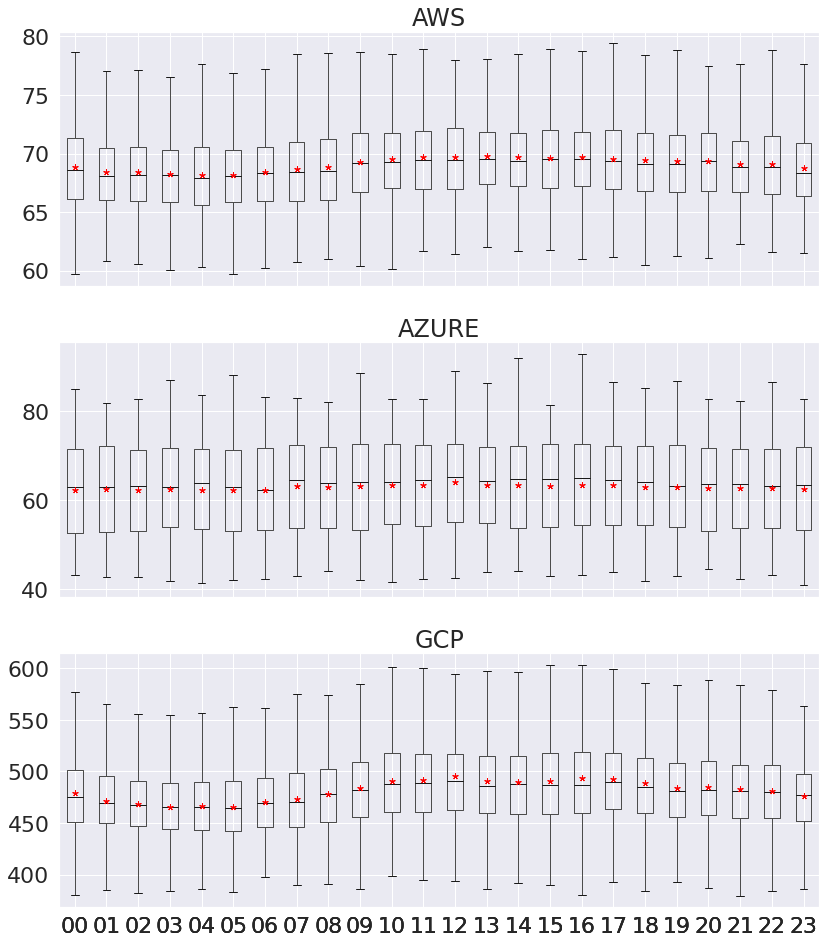

In [19]:
sns.set(font_scale=2)  
fig, ax = plt.subplots(figsize=(12,14), sharex=True, nrows=3)

bxpaws   = boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'observed')
bxpazure = boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'observed')
bxpgcp   = boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'observed')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_observed_hourly_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

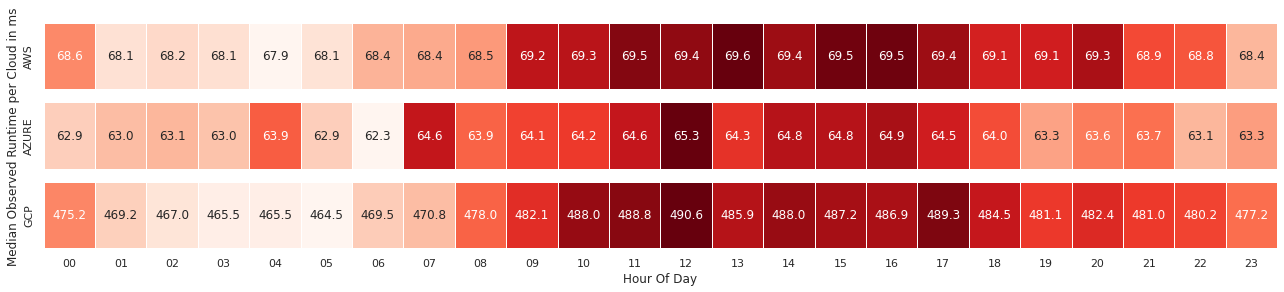

In [20]:
col = 'observed'
with_tz = True
strftime = '%H'
sns.set(font_scale=1)
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, axes = plt.subplots(figsize=(18,4), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Observed Runtime per Cloud in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_global_only'])

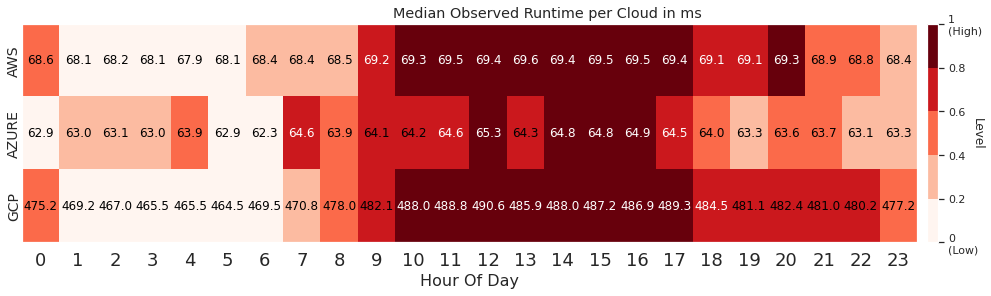

In [21]:
col = 'observed'
with_tz = True
strftime = '%H'
sns.set(font_scale=1)
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, ax = plt.subplots(figsize=(15,4))
sns.set(font_scale=1)
tdf_aws = get_heatmap_dataset('AWS', with_tz, col, hm_decomp, strftime,with_regions=False)
tdf_azure = get_heatmap_dataset('AZURE', with_tz, col, hm_decomp, strftime, with_regions=False)
tdf_gcp = get_heatmap_dataset('GCP', with_tz, col, hm_decomp, strftime, with_regions=False)
full_tdfn = tdf_aws['normalized_df'].append(tdf_azure['normalized_df']).append(tdf_gcp['normalized_df'])
full_tdfd = tdf_aws['data_df'].append(tdf_azure['data_df']).append(tdf_gcp['data_df'])

ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=14)

heatmap_improved(ax, full_tdfn, full_tdfd, '', 'Hour Of Day', label_coords=tuple((4, 0.5)))
fig.suptitle('Median Observed Runtime per Cloud in ms')
fig.tight_layout(pad=0)

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_global_only_improved'])

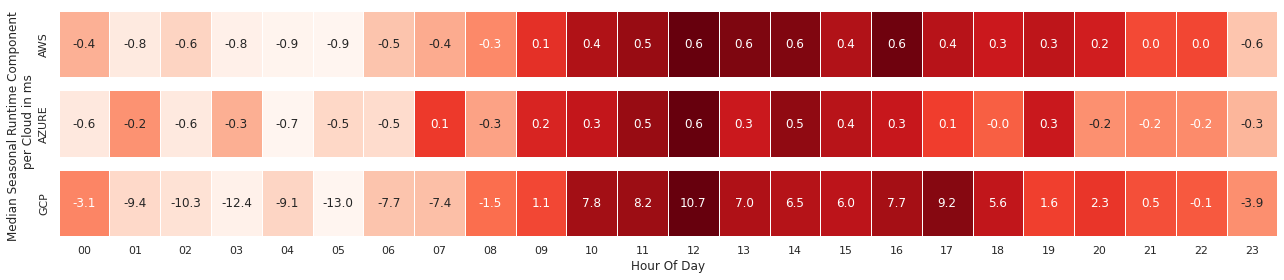

In [22]:
col = 'seasonal'
with_tz = True
strftime = '%H'
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, axes = plt.subplots(figsize=(18,4), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Seasonal Runtime Component \n per Cloud in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_global_only'])

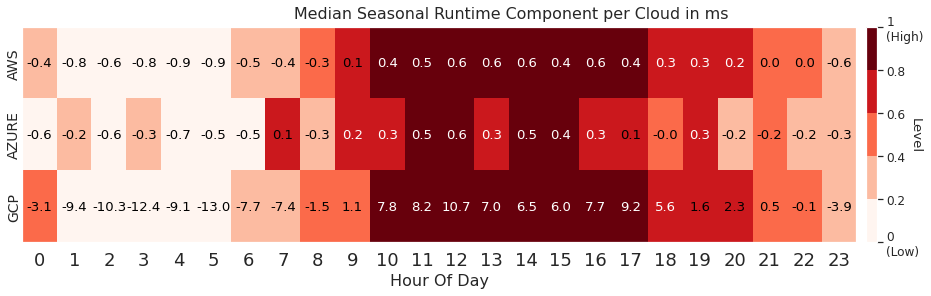

In [23]:
col = 'seasonal'
with_tz = True
strftime = '%H'
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'

fig, ax = plt.subplots(figsize=(14,4))
sns.set(font_scale=1.1)

tdf_aws = get_heatmap_dataset('AWS', with_tz, col, hm_decomp, strftime,with_regions=False)
tdf_azure = get_heatmap_dataset('AZURE', with_tz, col, hm_decomp, strftime, with_regions=False)
tdf_gcp = get_heatmap_dataset('GCP', with_tz, col, hm_decomp, strftime, with_regions=False)
full_tdfn = tdf_aws['normalized_df'].append(tdf_azure['normalized_df']).append(tdf_gcp['normalized_df'])
full_tdfd = tdf_aws['data_df'].append(tdf_azure['data_df']).append(tdf_gcp['data_df'])
    
heatmap_improved(ax, full_tdfn, full_tdfd, '', 'Hour Of Day', label_coords=tuple((4, 0.5)))

ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=14)


fig.suptitle('Median Seasonal Runtime Component per Cloud in ms')
fig.tight_layout(pad=0)
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_global_only_improved'])

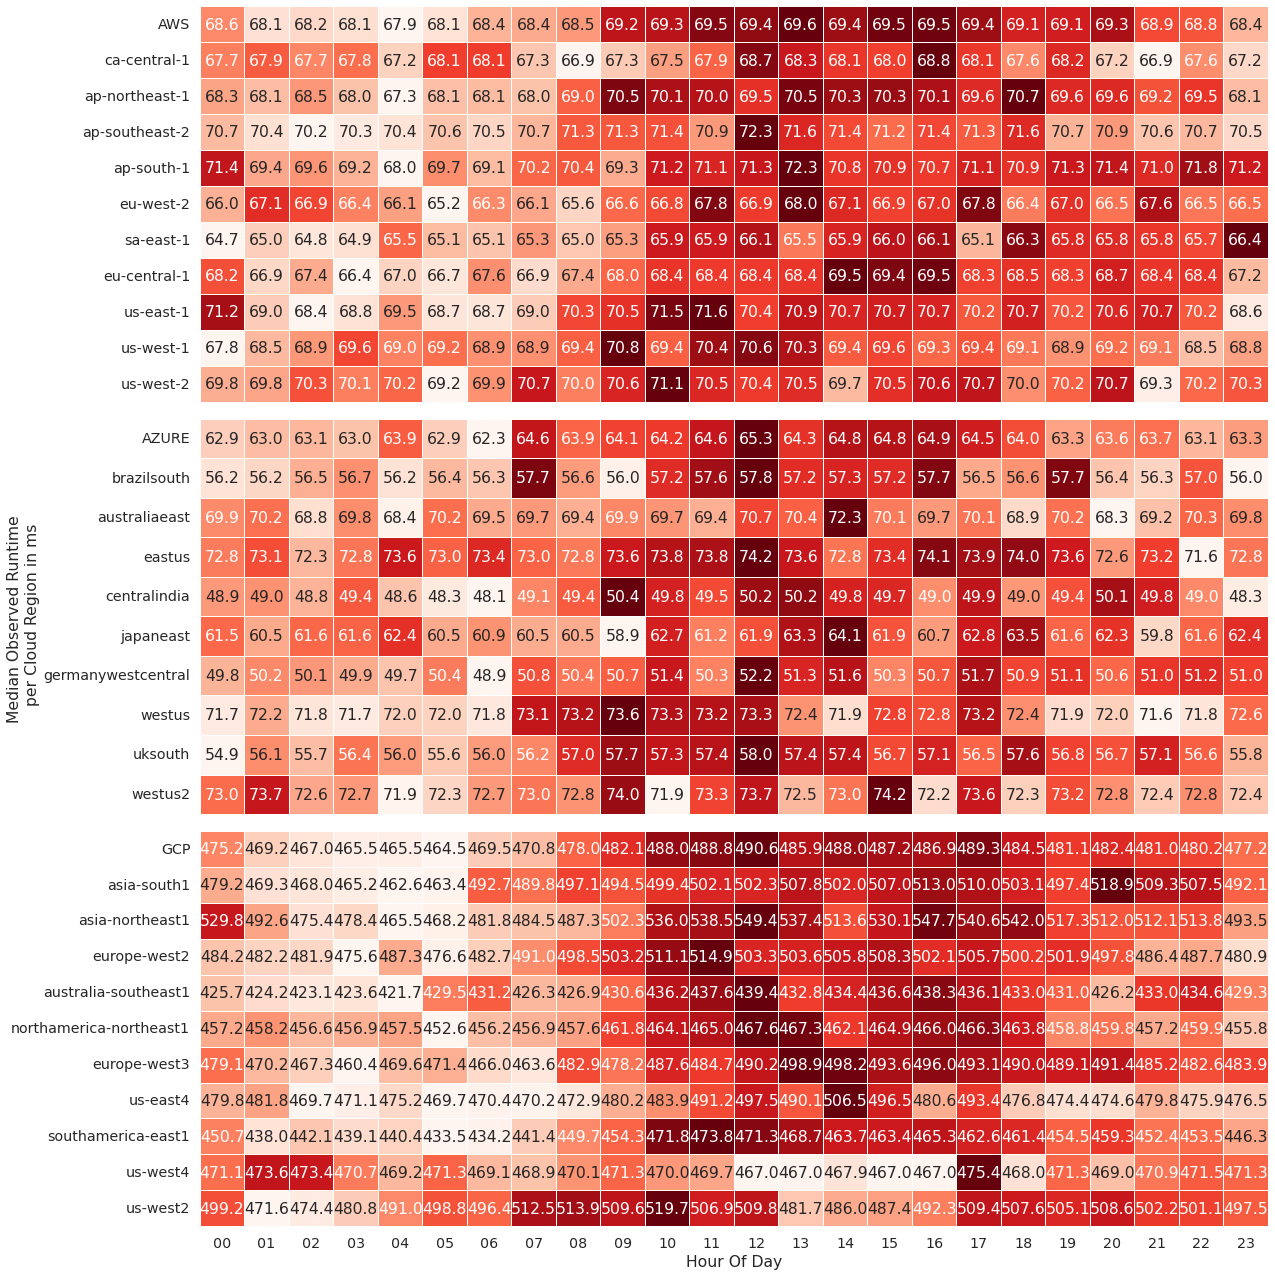

In [24]:
sns.set(font_scale=1.3)
col = 'observed'
with_tz = True
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, axes = plt.subplots(figsize=(18,18), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Observed Runtime \n per Cloud Region in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_regional'])

/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


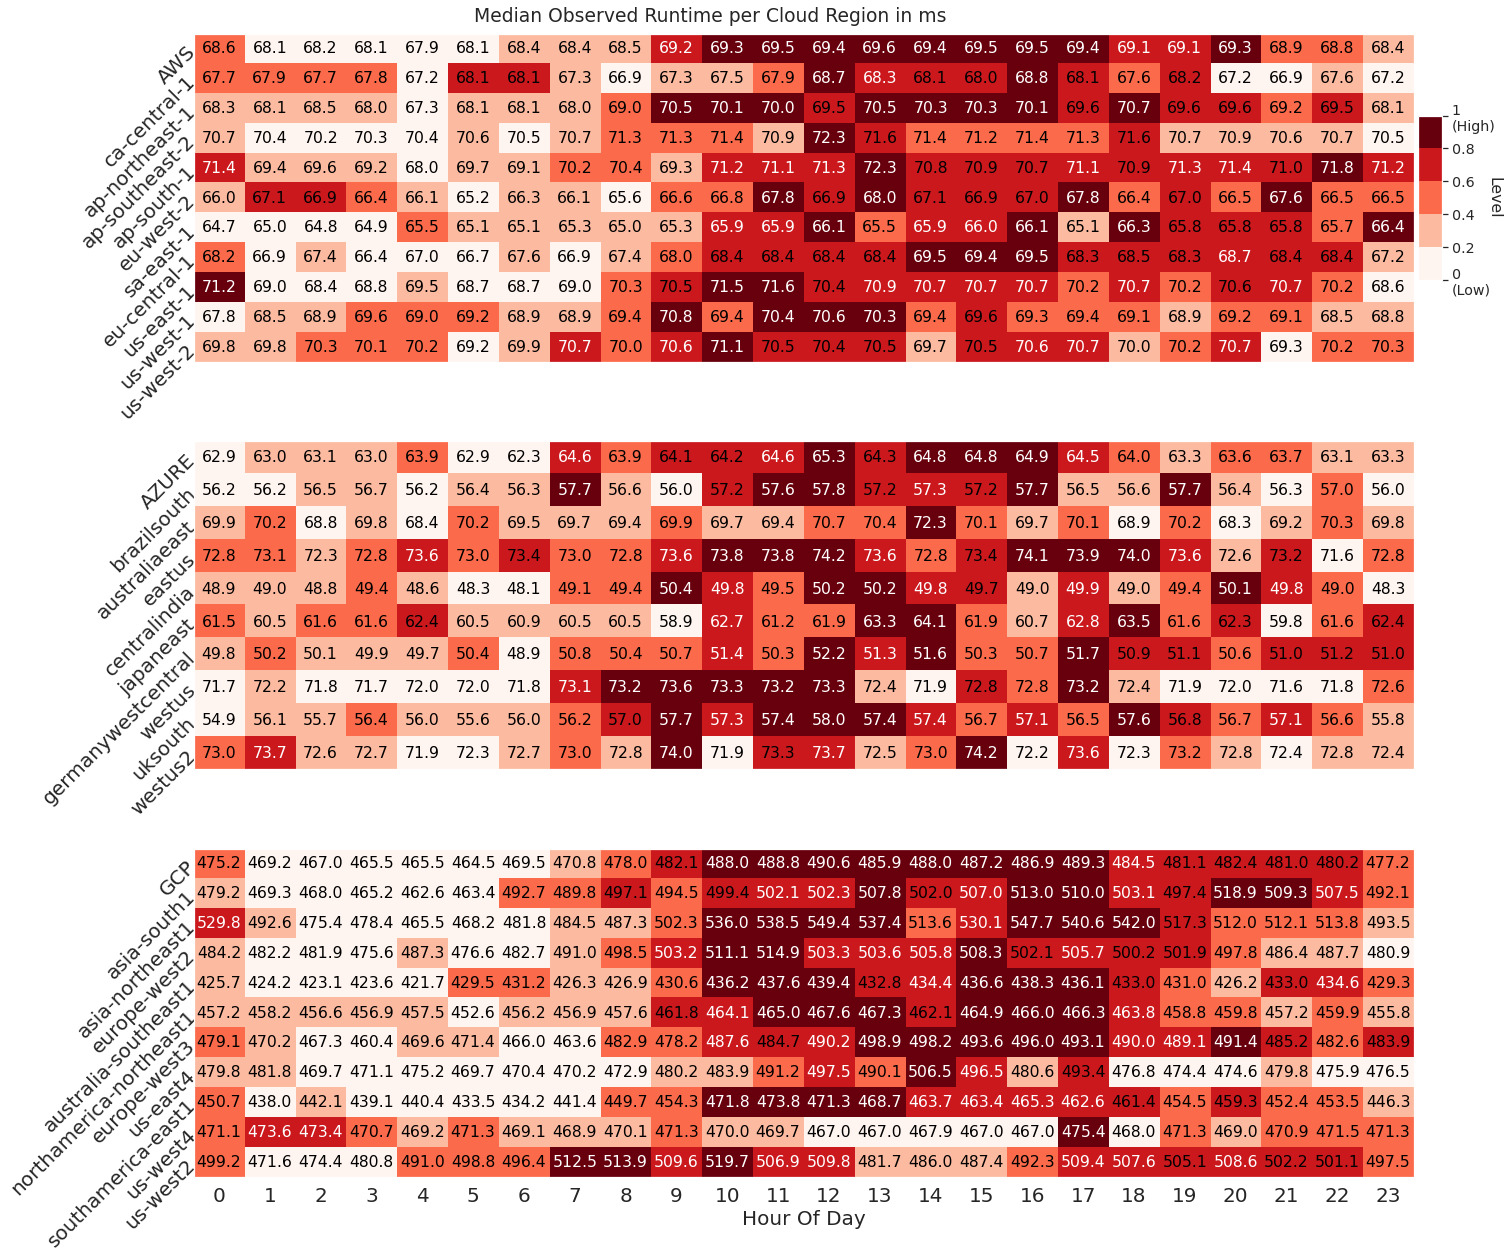

In [25]:
col = 'observed'
with_tz = True
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'

fig, ax = plt.subplots(figsize=(20,18), sharex=True, nrows=3)
sns.set(font_scale=1.3)

provider = "AWS"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[0], full_tdfn, full_tdfd, '' , '', rot=0, cbarstrink=0.5, label_coords=tuple((2.8, 0.5)))

labels = ax[0].yaxis.get_ticklabels()
ax[0].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

provider = "AZURE"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[1], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[1].yaxis.get_ticklabels()
ax[1].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")


provider = "GCP"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[2], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[2].yaxis.get_ticklabels()
ax[2].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

ax[1].set_ylabel('')
ax[2].set_xlabel(x_label)

for axi in ax:
    axi.xaxis.label.set_size(20)
    axi.tick_params(axis='x', which='major', labelsize=20)
    axi.tick_params(axis='y', which='major', labelsize=20)

fig.suptitle('Median Observed Runtime per Cloud Region in ms')
fig.tight_layout()

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_regional_improved'])

/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


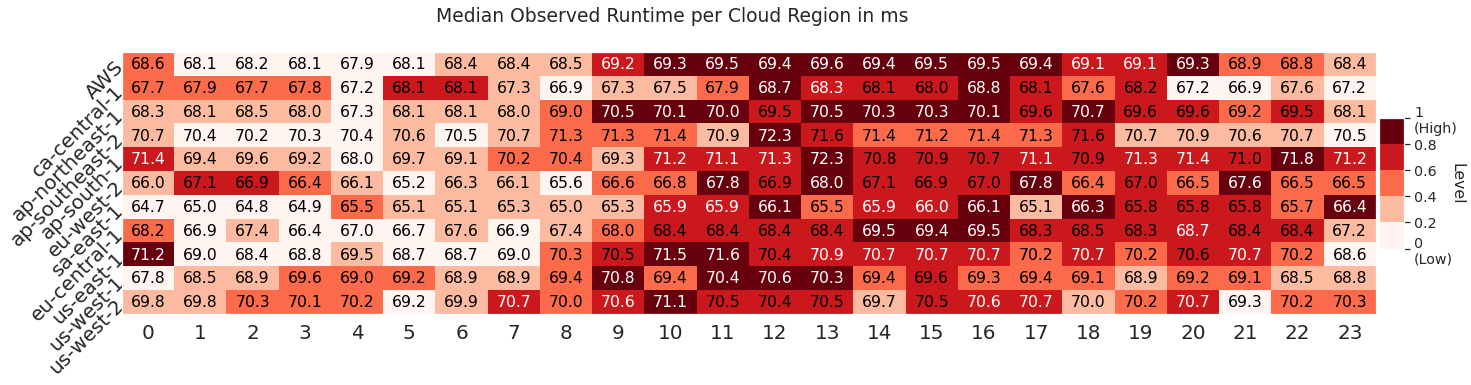

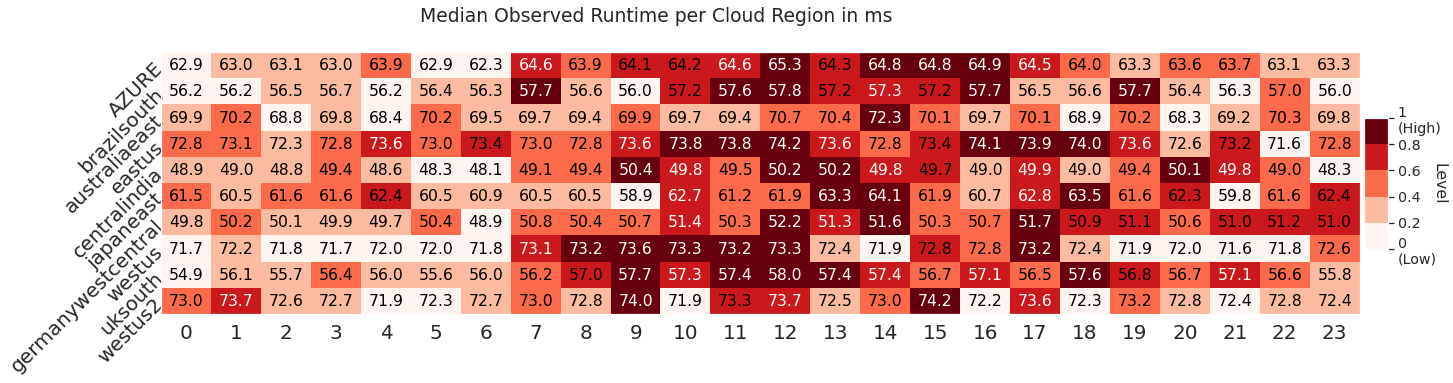

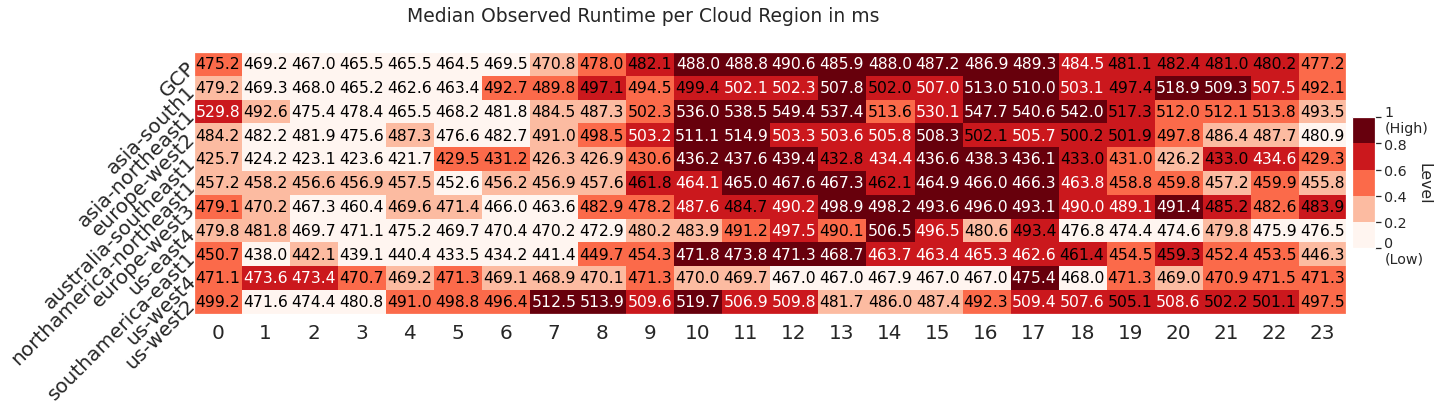

In [37]:
col = 'observed'
with_tz = True
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'

provider = "AWS"
for provider in ['AWS', 'AZURE', 'GCP']:
    fig, ax = plt.subplots(figsize=(20,5), sharex=True)
    sns.set(font_scale=1.3)
    tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
    full_tdfn = tdfp['normalized_df']
    full_tdfd = tdfp['data_df']

    heatmap_improved(ax, full_tdfn, full_tdfd, '' , '', rot=0, cbarstrink=0.5, label_coords=tuple((2.8, 0.5)))
    fig.suptitle('Median Observed Runtime per Cloud Region in ms')
    ax.xaxis.label.set_size(20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=20)
    fig.tight_layout()

    labels = ax.yaxis.get_ticklabels()
    ax.yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_{provider}_runtime_regional_improved'])

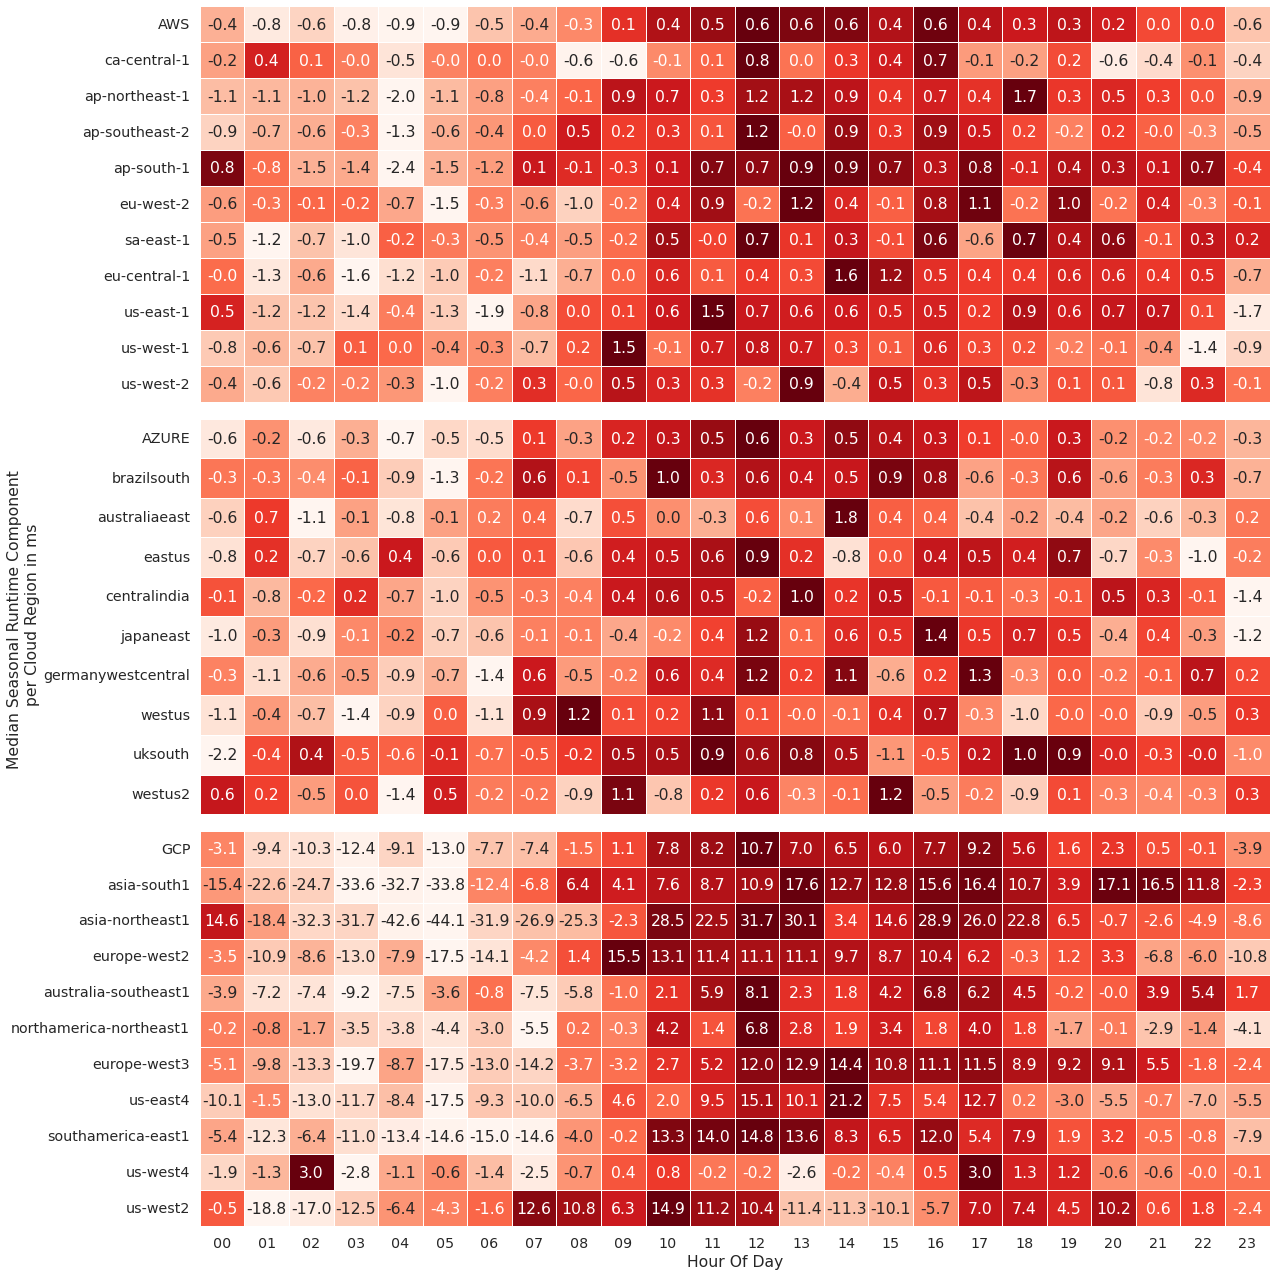

In [26]:
col = 'seasonal'
with_tz = True
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, axes = plt.subplots(figsize=(18,18), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Seasonal Runtime Component \n per Cloud Region in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_regional'])

/home/leonard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


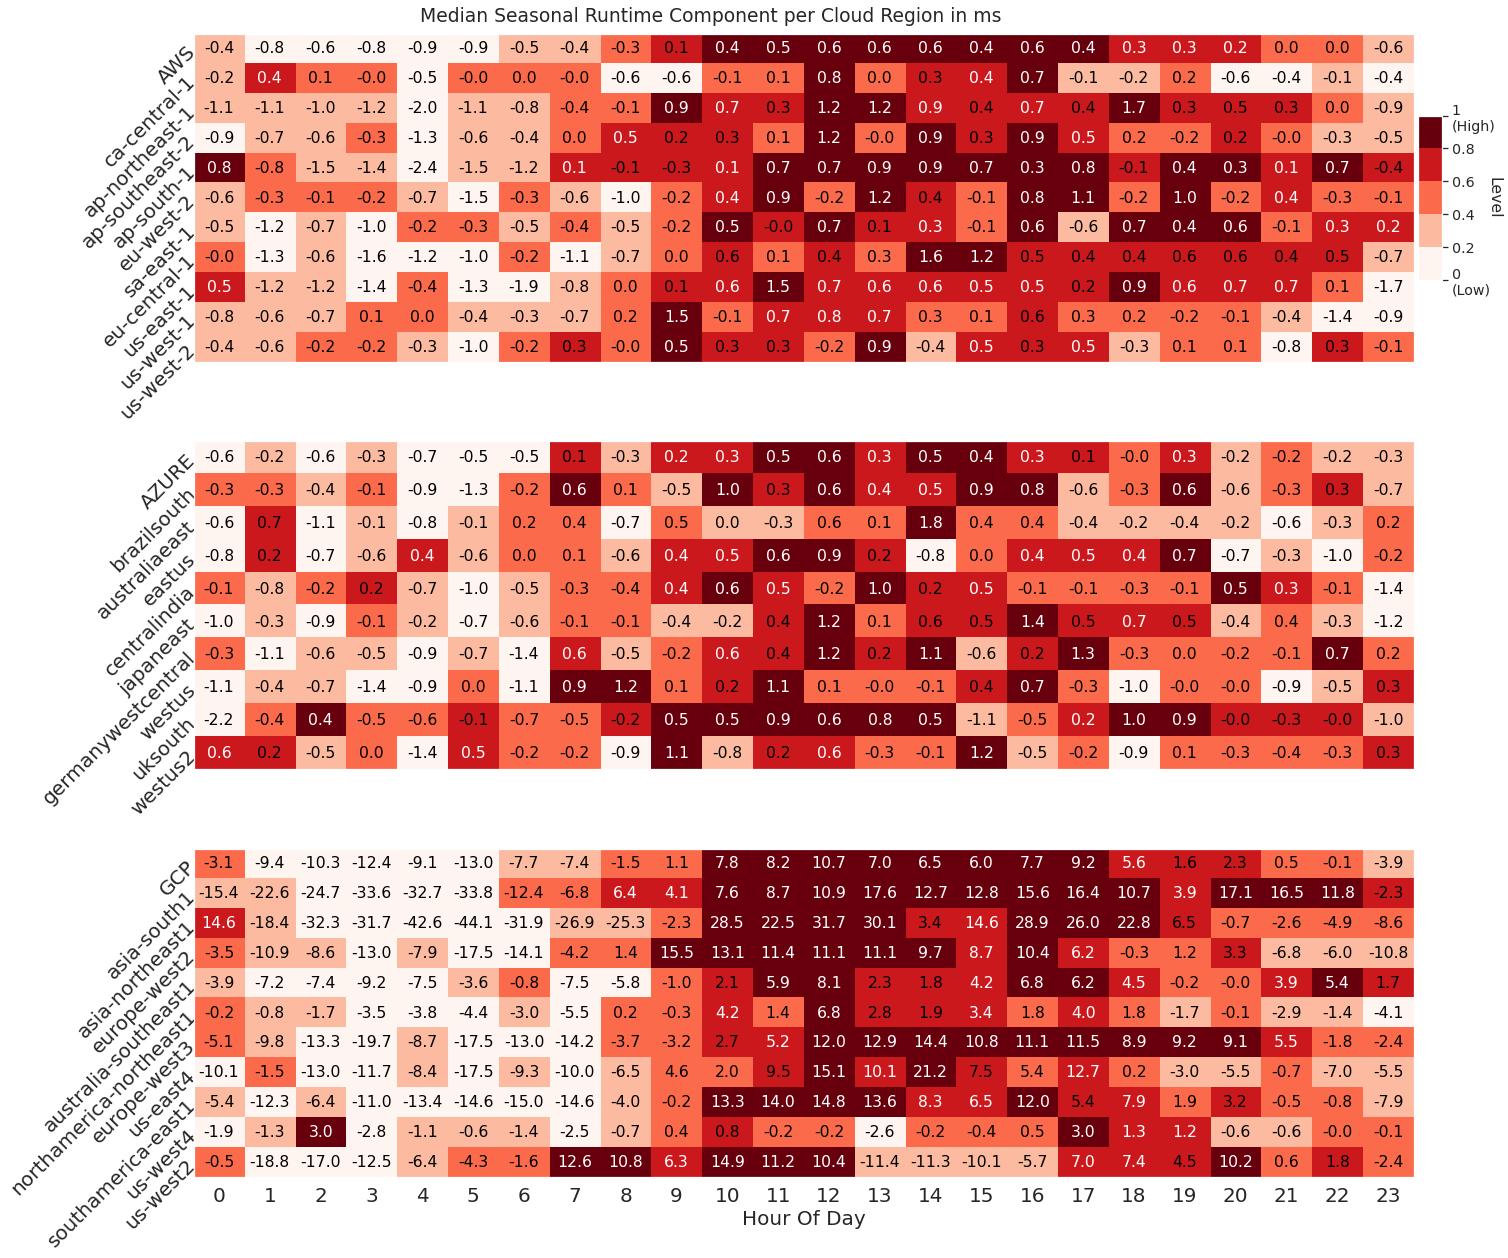

In [27]:
col = 'seasonal'
with_tz = True
hm_decomp = decomp_hourly
x_label = 'Hour Of Day'
fig, ax = plt.subplots(figsize=(20,18), sharex=True, nrows=3)
sns.set(font_scale=1.3)

provider = "AWS"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[0], full_tdfn, full_tdfd, '' , '', rot=0, cbarstrink=0.5, label_coords=tuple((2.8, 0.5)))

labels = ax[0].yaxis.get_ticklabels()
ax[0].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")


provider = "AZURE"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[1], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[1].yaxis.get_ticklabels()
ax[1].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")


provider = "GCP"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[2], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[2].yaxis.get_ticklabels()
ax[2].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

fig.suptitle('Median Seasonal Runtime Component per Cloud Region in ms')
ax[1].set_ylabel('')
ax[2].set_xlabel(x_label)

for axi in ax:
    axi.xaxis.label.set_size(20)
    axi.tick_params(axis='x', which='major', labelsize=20)
    axi.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_hourly_{col}_runtime_regional_improved'])

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

bxpaws   = boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'trend')
bxpazure = boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'trend')
bxpgcp   = boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'trend')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_trend_hourly_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, nrows=3)

bxpaws   = boxplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'seasonal')
bxpazure = boxplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'seasonal')
bxpgcp   = boxplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'seasonal')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_seasonal_hourly_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, nrows=3)

vioaws   = violinplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'observed')
vioazure = violinplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'observed')
viogcp   = violinplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'observed')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_observed_hourly_overview_violin'],
             vioaws=vioaws,
             vioazure=vioazure,
             viogcp=viogcp)

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

vioaws   = violinplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'trend')
vioazure = violinplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'trend')
viogcp   = violinplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'trend')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_trend_hourly_overview_violin'],
             vioaws=vioaws,
             vioazure=vioazure,
             viogcp=viogcp)

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

vioaws   = violinplot_hourly(aws_hourly_decomposes, ax[0], 'AWS', 'seasonal')
vioazure = violinplot_hourly(azure_hourly_decomposes, ax[1], 'AZURE', 'seasonal')
viogcp   = violinplot_hourly(gcp_hourly_decomposes, ax[2], 'GCP', 'seasonal')
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', 'runtime_seasonal_hourly_overview_violin'],
             vioaws=vioaws,
             vioazure=vioazure,
             viogcp=viogcp)

In [ ]:
sns.set(font_scale=2)  
fig, ax = plt.subplots(figsize=(12,14), sharex=True, nrows=3)

bxpaws   = boxplot_daily(aws_daily_decomposes,   ax[0], 'AWS', 'observed')
bxpazure = boxplot_daily(azure_daily_decomposes, ax[1], 'AZURE', 'observed')
bxpgcp   = boxplot_daily(gcp_daily_decomposes,   ax[2], 'GCP', 'observed')

# Plot Weekdays
ax[0].set_xticklabels(3*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_observed_daily_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

In [ ]:
sns.set(font_scale=2)  
fig, ax = plt.subplots(figsize=(12,14), sharex=True, nrows=3)

bxpaws   = boxplot_daily(aws_daily_decomposes,   ax[0], 'AWS', 'observed')
bxpazure = boxplot_daily(azure_daily_decomposes, ax[1], 'AZURE', 'observed')
bxpgcp   = boxplot_daily(gcp_daily_decomposes,   ax[2], 'GCP', 'observed')

# Plot Weekdays
ax[0].set_xticklabels(3*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_trend_daily_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

In [ ]:
sns.set(font_scale=2)  
fig, ax = plt.subplots(figsize=(12,14), sharex=True, nrows=3)

bxpaws   = boxplot_daily(aws_daily_decomposes,   ax[0], 'AWS', 'seasonal')
bxpazure = boxplot_daily(azure_daily_decomposes, ax[1], 'AZURE', 'seasonal')
bxpgcp   = boxplot_daily(gcp_daily_decomposes,   ax[2], 'GCP', 'seasonal')

# Plot Weekdays
ax[0].set_xticklabels(3*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_seasonal_daily_overview'],
             bxpaws=bxpaws,
             bxpazure=bxpazure,
             bxpgcp=bxpgcp)

In [ ]:
col = 'observed'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'
fig, axes = plt.subplots(figsize=(18,4), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_global_only'])

In [ ]:
col = 'observed'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'

fig, ax = plt.subplots(figsize=(14,4))
sns.set(font_scale=1.8)

tdf_aws = get_heatmap_dataset('AWS', with_tz, col, hm_decomp, strftime,with_regions=False)
tdf_azure = get_heatmap_dataset('AZURE', with_tz, col, hm_decomp, strftime, with_regions=False)
tdf_gcp = get_heatmap_dataset('GCP', with_tz, col, hm_decomp, strftime, with_regions=False)
full_tdfn = tdf_aws['normalized_df'].append(tdf_azure['normalized_df']).append(tdf_gcp['normalized_df'])
full_tdfd = tdf_aws['data_df'].append(tdf_azure['data_df']).append(tdf_gcp['data_df'])
    
heatmap_improved(ax, full_tdfn, full_tdfd, '', 'Day Of Week', label_coords=tuple((6, 0.5)))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('Median Observed Runtime per Cloud in ms')
fig.tight_layout(pad=0)

ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=14)

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_global_only_improved'])

In [ ]:
col = 'seasonal'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'
fig, axes = plt.subplots(figsize=(14,4), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Seasonal Runtime Component \n per Cloud Region in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime, with_regions=False)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_global_only'])

In [ ]:
col = 'seasonal'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'

fig, ax = plt.subplots(figsize=(14,4))
sns.set(font_scale=1.8)

tdf_aws = get_heatmap_dataset('AWS', with_tz, col, hm_decomp, strftime,with_regions=False)
tdf_azure = get_heatmap_dataset('AZURE', with_tz, col, hm_decomp, strftime, with_regions=False)
tdf_gcp = get_heatmap_dataset('GCP', with_tz, col, hm_decomp, strftime, with_regions=False)
full_tdfn = tdf_aws['normalized_df'].append(tdf_azure['normalized_df']).append(tdf_gcp['normalized_df'])
full_tdfd = tdf_aws['data_df'].append(tdf_azure['data_df']).append(tdf_gcp['data_df'])
    
heatmap_improved(ax, full_tdfn, full_tdfd, '', 'Day Of Week', label_coords=tuple((6, 0.5)))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('Median Seasonal Runtime Component per Cloud Region in ms')
fig.tight_layout(pad=0)

ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=14)

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_global_only_improved'])

In [ ]:
col = 'observed'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'
fig, axes = plt.subplots(figsize=(18,18), sharex=True, nrows=3)
sns.set(font_scale=1.6)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Observed Runtime \n per Cloud in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_regional'])

In [ ]:
col = 'observed'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'

fig, ax = plt.subplots(figsize=(16,18), sharex=True, nrows=3)
sns.set(font_scale=1.6)

provider = "AWS"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[0], full_tdfn, full_tdfd, '' , '', rot=0, cbarstrink=0.5, label_coords=tuple((4, 0.5)))


labels = ax[0].yaxis.get_ticklabels()
ax[0].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

provider = "AZURE"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[1], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)


labels = ax[1].yaxis.get_ticklabels()
ax[1].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")



provider = "GCP"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[2], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[2].yaxis.get_ticklabels()
ax[2].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

fig.suptitle('Median Observed Runtime per Cloud in ms')
ax[1].set_ylabel('')
ax[2].set_xlabel(x_label)
ax[2].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for axi in ax:
    axi.xaxis.label.set_size(20)
    axi.tick_params(axis='x', which='major', labelsize=20)
    axi.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_regional_improved'])

In [ ]:
col = 'seasonal'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'
fig, axes = plt.subplots(figsize=(18,18), sharex=True, nrows=3)

# AWS
ax = axes[0]
provider = 'AWS'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')

# AZURE
ax = axes[1]
provider = 'AZURE'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel('')
ax.set_ylabel('Median Seasonal Runtime Component \n per Cloud Region in ms')

# GCP
ax = axes[2]
provider = 'GCP'
tdf = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime)
ax = plot_heatmap(tdf, ax)
ax.set_xlabel(x_label)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.tight_layout()
utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_regional'])

In [ ]:
col = 'seasonal'
with_tz = True
strftime = '%w'
hm_decomp = decomp_daily
x_label = 'Day Of Week'

fig, ax = plt.subplots(figsize=(16,18), sharex=True, nrows=3)
sns.set(font_scale=1.6)

provider = "AWS"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[0], full_tdfn, full_tdfd, '' , '', rot=0, cbarstrink=0.5, label_coords=tuple((4, 0.5)))

labels = ax[0].yaxis.get_ticklabels()
ax[0].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

provider = "AZURE"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[1], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[1].yaxis.get_ticklabels()
ax[1].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

provider = "GCP"
tdfp = get_heatmap_dataset(provider, with_tz, col, hm_decomp, strftime,with_regions=True)
full_tdfn = tdfp['normalized_df']
full_tdfd = tdfp['data_df']

heatmap_improved(ax[2], full_tdfn, full_tdfd, '' , '', rot=0, with_cbar=False)

labels = ax[2].yaxis.get_ticklabels()
ax[2].yaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")

fig.suptitle('Median Seasonal Runtime Component per Cloud Region in ms')
ax[1].set_ylabel('')
ax[2].set_xlabel(x_label)
ax[2].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for axi in ax:
    axi.xaxis.label.set_size(20)
    axi.tick_params(axis='x', which='major', labelsize=20)
    axi.tick_params(axis='y', which='major', labelsize=20)

fig.tight_layout()

utils.savefig(fig, ['temporal_analysis', 'summary', f'heatmap_daily_{col}_runtime_regional_improved'])

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

vioaws =   violinplot_daily(aws_daily_decomposes,   ax[0], 'AWS', 'observed')
vioazure = violinplot_daily(azure_daily_decomposes, ax[1], 'AZURE', 'observed')
viogcp =   violinplot_daily(gcp_daily_decomposes,   ax[2], 'GCP', 'observed')

ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_observed_daily_overview_violin'],
              vioaws = vioaws,
              vioazure = vioazure,
              viogcp = viogcp)

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

vioaws =   violinplot_daily(aws_daily_decomposes,   ax[0], 'AWS', 'trend')
vioazure = violinplot_daily(azure_daily_decomposes, ax[1], 'AZURE', 'trend')
viogcp =   violinplot_daily(gcp_daily_decomposes,   ax[2], 'GCP', 'trend')

# Plot Weekdays
ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_trend_daily_overview_violin'],
              vioaws = vioaws,
              vioazure = vioazure,
              viogcp = viogcp
             )

In [ ]:
sns.set(font_scale=1)    
fig, ax = plt.subplots(figsize=(18,6), sharex=True, ncols=3)

vioaws =   violinplot_daily(aws_daily_decomposes,   ax[0], 'AWS')
vioazure = violinplot_daily(azure_daily_decomposes, ax[1], 'AZURE')
viogcp =   violinplot_daily(gcp_daily_decomposes,   ax[2], 'GCP')

# Plot Weekdays
ax[0].set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

fig.suptitle('')
fig.tight_layout()
utils.savefig(fig, 
              ['temporal_analysis', 'summary', 'runtime_seasonal_daily_overview_violin'],
              vioaws = vioaws,
              vioazure = vioazure,
              viogcp = viogcp
             )

In [ ]:
def dict_to_str(dictdata):
    result = ""
    for key, data in dictdata.items():
        result += str(key)
        result += '\n'
        result += str(data)
        result += '\n\n'
    return result

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['seasonal', 'observed', 'trend']
sns.set(font_scale=1.6)
for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_hourly))
    
    num_regions = len(provider_decomposes)
    
    for col in cols:
        fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
        from itertools import chain
        axis = list(chain.from_iterable(axis))

        cax = 0
        bxpdata = {}
        for decomp in provider_decomposes:
            bxpdata[decomp['parameters']['region']] = boxplot_hourly([decomp], axis[cax], decomp['parameters']['region'], col)
            cax += 1
        if provider == 'AZURE':
            axis[9].set_facecolor('none')
            axis[9].set_yticks([])
        
        fig.suptitle('')
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_hourly'], bxpdata=dict_to_str(bxpdata))

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['seasonal', 'observed', 'trend']
sns.set(font_scale=1.6)
for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_hourly))
    num_regions = len(provider_decomposes)
    for col in cols:
        for decomp in provider_decomposes:
            fig, axis = plt.subplots(figsize=(9,4), sharey=False, sharex=True)
            region = decomp['parameters']['region']
            bxpdata[decomp['parameters']['region']] = boxplot_hourly([decomp], axis, region, col)
            axis.set_ylabel(col)
            fig.suptitle('')
            fig.tight_layout()
            utils.savefig(fig, ['temporal_analysis', 'summary', provider, 'regions', f'{region}_{col}_runtime_hourly'], bxpdata=dict_to_str(bxpdata))

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['observed', 'trend', 'seasonal']

for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_daily))
    
    num_regions = len(provider_decomposes)
    
    for col in cols:
        fig, axis = plt.subplots(figsize=(12,8), sharey=False, sharex=True, nrows = 1, ncols=1)
        from itertools import chain
        # axis = list(chain.from_iterable(axis))

        #cax = 0
        fdf = None
        for decomp in provider_decomposes:
            timezone = decomp['parameters']['timezone']
            if col == 'observed':
                series = getattr(decomp['decomposition']['data'], col)['runtime'].rename(col)
                series = series.astype(np.float64) #TODO: check if fix neccesary for vio (box not)
            else:
                series = getattr(decomp['decomposition']['data'], col).rename(col)
            
            ddf = pd.DataFrame(series)
            ddf.set_index(pd.DatetimeIndex(ddf.index), drop=False, inplace=False)
            ddf['hist'] = ddf.index.tz_localize('UTC').tz_convert(timezone).strftime("%w")
            ddf['region'] = decomp['parameters']['region']
    
            if fdf is None:
                fdf = ddf
            else:
                fdf = fdf.append(ddf)
        plotdf = fdf.groupby(['region', 'hist']).median()
        plotdf = plotdf.reset_index()
        
        # print(plotdf)
        pivotdf = plotdf.reset_index().pivot(index='hist', columns='region', values=col)
        pivotdf.plot.bar(ax=axis, width=0.9)
        axis.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
        
        axis.set_ylabel(f'Runtime {col}')
        axis.set_xlabel('')
        
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_daily_overview_bar'])

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['observed', 'trend', 'seasonal']

for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_hourly))
    
    num_regions = len(provider_decomposes)
    
    for col in cols:
        fig, axis = plt.subplots(figsize=(12,8), sharey=False, sharex=True, nrows = 1, ncols=1)
        from itertools import chain
        # axis = list(chain.from_iterable(axis))

        #cax = 0
        fdf = None
        for decomp in provider_decomposes:
            timezone = decomp['parameters']['timezone']
            if col == 'observed':
                series = getattr(decomp['decomposition']['data'], col)['runtime'].rename(col)
                series = series.astype(np.float64) #TODO: check if fix neccesary for vio (box not)
            else:
                series = getattr(decomp['decomposition']['data'], col).rename(col)
            
            ddf = pd.DataFrame(series)
            ddf.set_index(pd.DatetimeIndex(ddf.index), drop=False, inplace=False)
            ddf['hist'] = ddf.index.tz_localize('UTC').tz_convert(timezone).strftime("%H")
            ddf['region'] = decomp['parameters']['region']
    
            if fdf is None:
                fdf = ddf
            else:
                fdf = fdf.append(ddf)
        plotdf = fdf.groupby(['region', 'hist']).median()
        plotdf = plotdf.reset_index()
        
        # print(plotdf)
        pivotdf = plotdf.reset_index().pivot(index='hist', columns='region', values=col)
        pivotdf.plot.bar(ax=axis, width=0.9)
        
        axis.set_ylabel(f'Runtime {col}')
        axis.set_xlabel('')
        
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_hourly_overview_bar'])

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['observed', 'trend', 'seasonal']

for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_hourly))
    for col in cols:
        fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
        from itertools import chain
        axis = list(chain.from_iterable(axis))

        cax = 0
        viodata = {}
        for decomp in provider_decomposes:
            viodata[decomp['parameters']['region']] = violinplot_hourly([decomp], axis[cax], decomp['parameters']['region'], col)
            cax += 1
        if provider == 'AZURE':
            axis[9].set_facecolor('none')
            axis[9].set_yticks([])
            
        fig.suptitle('')
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_hourly_violin'], viodata=dict_to_str(viodata))

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['observed', 'trend', 'seasonal']
sns.set(font_scale=1.6)
for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_daily))
    
    num_regions = len(provider_decomposes)
    
    for col in cols:
        fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
        from itertools import chain
        axis = list(chain.from_iterable(axis))

        cax = 0
        bxpdata = {}
        for decomp in provider_decomposes:
            bxpdata[decomp['parameters']['region']] = boxplot_daily([decomp], axis[cax], decomp['parameters']['region'], col)
            cax += 1
        if provider == 'AZURE':
            axis[9].set_facecolor('none')
            axis[9].set_yticks([])

        axis[9].set_xticklabels(num_regions*['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
        fig.suptitle('')
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_daily'], bxpdata=dict_to_str(bxpdata))

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['seasonal', 'observed', 'trend']
sns.set(font_scale=1.6)
for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_daily))
    num_regions = len(provider_decomposes)
    for col in cols:
        for decomp in provider_decomposes:
            fig, axis = plt.subplots(figsize=(9,4), sharey=False, sharex=True)
            region = decomp['parameters']['region']
            bxpdata[decomp['parameters']['region']] = boxplot_daily([decomp], axis, region, col)
            axis.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
            axis.set_ylabel(col)
            fig.suptitle('')
            fig.tight_layout()
            utils.savefig(fig, ['temporal_analysis', 'summary', provider, 'regions', f'{region}_{col}_runtime_daily'], bxpdata=dict_to_str(bxpdata))

In [ ]:
providers = ['AWS', 'AZURE', 'GCP']
cols = ['observed', 'trend', 'seasonal']

for provider in providers:
    provider_decomposes = list(filter(lambda decomp: decomp['parameters']['provider'] == provider, decomp_daily))
    for col in cols:
        fig, axis = plt.subplots(figsize=(18,14), sharey=False, sharex=True, nrows = 5, ncols=2)
        from itertools import chain
        axis = list(chain.from_iterable(axis))

        cax = 0
        viodata = {}
        for decomp in provider_decomposes:
            viodata[decomp['parameters']['region']] = violinplot_daily([decomp], axis[cax], decomp['parameters']['region'], col)
            cax += 1
        if provider == 'AZURE':
            axis[9].set_facecolor('none')
            axis[9].set_yticks([])
        
        fig.suptitle('')
        fig.tight_layout()
        utils.savefig(fig, ['temporal_analysis', 'summary', provider, f'{col}_runtime_daily_violin'], viodata=dict_to_str(viodata))

In [ ]:
from notebook_shared import decomposeutils 

for dc in decomp_hourly: 
    p = dc['parameters']['provider']
    r = dc['parameters']['region']
    fig = decomposeutils.plot_decompose(dc['decomposition']['data'], dc['parameters']['timezone'], font_scale=2.4, figsize=(20,14))
    utils.savefig(fig, ['temporal_analysis', 'decomps', p, f'{r}_decomp_hourly'])
    plt.close()

In [ ]:
def output_casetable(casetab):
    output = ""

    # output += r'\begin{table}[]\begin{tabular}{lll} &  &  \\ &  &  \\ &  & \end{tabular}\end{table}'
    output += r'\begin{table}[h]\begin{tabular}{ll|cccc||cccc} '+ "\n"
    output += r' Provider & Region & \multicolumn{4}{c||}{Case Hourly} & \multicolumn{4}{c}{Case Daily} \\' + "\n"
    output += r'          &        & 1 & 2 & 3 & 4 & 1 & 2 & 3 & 4  \\' + "\n"
    for provider, regions in casetab.items():
        grp = provider
        
        for region, cases in regions.items():
            # print(provider, region, cases['hourly'], cases['daily'])
            hourly_case_1 = ""
            if cases['hourly'] == "case_1":
                hourly_case_1 = "X"
            hourly_case_2 = ""
            if cases['hourly'] == "case_2":
                hourly_case_2 = "X"
            hourly_case_3 = ""
            if cases['hourly'] == "case_3":
                hourly_case_3 = "X"
            hourly_case_4 = ""
            if cases['hourly'] == "case_4":
                hourly_case_4 = "X"
            
            
            daily_case_1 = ""
            if cases['daily'] == "case_1":
                daily_case_1 = "X"
            daily_case_2 = ""
            if cases['daily'] == "case_2":
                daily_case_2 = "X"
            daily_case_3 = ""
            if cases['daily'] == "case_3":
                daily_case_3 = "X"
            daily_case_4 = ""
            if cases['daily'] == "case_4":
                daily_case_4 = "X"
            
            line = ""
            line += f' {grp} & {region} & {hourly_case_1} & {hourly_case_2} & {hourly_case_3} & {hourly_case_4}'
            line += f' &'
            line += f' {daily_case_1} & {daily_case_2} & {daily_case_3} & {daily_case_4} \\\\'
            line += "\n"
            
            grp = ""
            output += line
        
    output += r'\end{tabular}\end{table}'
    return output
# Latex(output_casetable(casetab))

In [ ]:
def create_casetab(hourly, daily):
    casetab = {}
    # Go Over Hourly
    for result in hourly:
        provider = result['parameters']['provider']
        region = result['parameters']['region']

        if provider not in casetab.keys():
            casetab[provider] = {}
        if region not in casetab[provider].keys():
            casetab[provider][region] = {}
            
        casetab[provider][region]['hourly'] = result['stats_test']['case']
    # Go Over Hourly
    for result in daily:
        provider = result['parameters']['provider']
        region = result['parameters']['region']

        if provider not in casetab.keys():
            casetab[provider] = {}
        if region not in casetab[provider].keys():
            casetab[provider][region] = {}

        casetab[provider][region]['daily'] = result['stats_test']['case']
    return casetab  

In [ ]:
casetab = create_casetab(decomp_hourly, decomp_daily)
output = output_casetable(casetab)
Latex(output)

In [ ]:
def create_casedf(data):
    data_dict = {'provider': [], 'region': [], 'case': []}
    
    # Go Over Hourly
    for result in data:
        provider = result['parameters']['provider']
        region = result['parameters']['region']
        data_dict['provider'].append(provider)
        data_dict['region'].append(region)
        data_dict['case'].append(int(result['stats_test']['case'].split('_')[1]))
        # TODO: Can add p value?
        # data_dict['data'].append(result['stats_test']['case'])
    df = pd.DataFrame(data_dict)
    df['Cloud Region'] = df['provider'] + ' ' + df['region']
    df = df.set_index('Cloud Region')
    return df['case']

hourly_casedf = create_casedf(decomp_hourly).rename('Hour Of Day')
daily_casedf = create_casedf(decomp_daily).rename('Day Of Week')
casedf = pd.merge(hourly_casedf, daily_casedf, right_index=True, left_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
sns.set(font_scale=1.8)

my_colors=[(1,0,0), (0.47,0.93,0.35), (0.59,0.15,0.33), (0.13,0.93,0.9)]
ax = sns.heatmap(casedf.transpose(), ax=ax, cmap=my_colors, linewidth=1, linecolor='w', square=True, cbar=False)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")


colorbar = ax.figure.colorbar(ax.collections[0], location='top',shrink=0.5)


colorbar.set_ticks([1.4,2.1,2.9,3.6])
colorbar.set_ticklabels(['Case 1','Case 2','Case 3', 'Case 4'])
fig.tight_layout(pad=0)

utils.savefig(fig, ['temporal_analysis', 'stattest', 'heatmap'])